# Evaluates our Base Model
I have not implemented a test set yet so this uses the validation set
and just generates some basic stats and pictures 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime
import re
import importlib

import sys
sys.path.append("..")

from modelUtils import loadCheckpoint, plotPredVsTrue, dotDict
from dataUtils import loadEnergyData, processData, energyDataset, getDatasets, normalizeAdjMat
from models.baseSTGCN import STGCN

In [3]:
# params
torch.manual_seed(0)
np.random.seed(0)

##### Load our args
config_file = "baseSTGCN_config"
c = importlib.import_module("configs."+config_file)
args = c.args

print(args)

# update args for evaluation purposes
args.save_seq = False
args.load_seq = True
args.seq_path = os.path.join("." + args.seq_path, "testingOnly")


processed_dir = "../data/processed/"

# loss functions to compute
mae_criterion = nn.L1Loss()
mse_criterion = nn.MSELoss()

{'historical_input': 24, 'forecast_output': 24, 'subset_feats': None, 'save_seq': False, 'load_seq': True, 'seq_path': './data/processed/nodeSequences', 'processing_function': <function processData at 0x0000012D10A252F0>, 'device': 'cuda', 'epochs': 200, 'batch_size': 64, 'lr': 0.01, 'model_name': 'baselineSTGCN.pth'}


In [66]:
energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 20, partial = True)
energy_demand.describe()

,hour,dow,month,year,holiday,voltage,solar_cosmo,solar_ecmwf,wind_cosmo,wind_ecmwf,load
count,499776.000000,499776.000000,499776.000000,499776.000000,499776.000000,499776.0,499757.000000,499776.000000,499776.000000,499776.000000,499776.000000
mean,11.500000,2.997263,6.521898,2012.999088,0.028285,380.0,0.249442,0.293798,0.158365,0.132349,198.752987
std,6.922193,2.001596,3.448990,0.816683,0.165785,0.0,0.374604,0.420520,0.181058,0.161001,286.553368
min,0.000000,0.000000,1.000000,2012.000000,0.000000,380.0,0.000000,0.000000,0.001300,0.000800,5.869500
25%,5.750000,1.000000,4.000000,2012.000000,0.000000,380.0,0.000000,0.000000,0.029700,0.023500,58.023800
50%,11.500000,3.000000,7.000000,2013.000000,0.000000,380.0,0.000000,0.000000,0.087700,0.070500,104.943300
75%,17.250000,5.000000,10.000000,2014.000000,0.000000,380.0,0.460600,0.605100,0.222000,0.177300,207.683200
max,23.000000,6.000000,12.000000,2014.000000,1.000000,380.0,1.369200,1.454100,0.999600,0.999200,1923.441300


In [12]:
# Get validation data
if args.load_seq:
    # get number of nodes to include
    files = os.listdir(args.seq_path)
    incl_nodes = max([int(re.search("\d{1,5}", f).group(0)) for f in files])
    _, adj_mat = loadEnergyData(processed_dir, incl_nodes = incl_nodes, partial = False)
    energy_demand = None
else:
    energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 20, partial = True)

_, val_dataset = getDatasets(args, energy_demand, validation_only = True)

val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)


# normalized adjacency matrix with self loop
adj_norm = normalizeAdjMat(adj_mat)
adj_norm = adj_norm.to(args['device']) 

val_dataset.inputs.shape, val_dataset.target.shape, adj_norm.shape

(torch.Size([90, 1049, 24, 12]),
 torch.Size([90, 1049, 24]),
 torch.Size([1049, 1049]))

In [14]:
# Model init
num_nodes = val_dataset.target.shape[1]
num_features = val_dataset.inputs.shape[3]

Gnet = STGCN(num_nodes,
             num_features,
             args.historical_input,
             args.forecast_output).to(device=args.device)

model = loadCheckpoint(Gnet, filename = "baselineSTGCN.pth", folder = '../savedModels')
model

STGCN(
  (block1): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(12, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(12, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(12, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (batch_norm): BatchNorm2d(1049, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): spatioTemporalBlock(
    (t1): temporalConv(
      (conv1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
    )
    (t2): temporalConv(
      (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1

In [15]:
# Get Predictions
val_predictions = []
val_target = []

mae_list = []
mse_list = []
rmse_list = []

with torch.no_grad():
    Gnet.eval()
    for vbatch_idx, (vfeatures, vtarget) in enumerate(val_loader):
        vfeatures = vfeatures.to(args.device)
        vtarget = vtarget.to(args.device)

        # predict 
        vpreds = Gnet(vfeatures, adj_norm)
        mse_loss = mse_criterion(vpreds, vtarget)
        mae_loss = mae_criterion(vpreds, vtarget)
        rmse_loss = torch.sqrt(mse_criterion(vpreds, vtarget))

        # storage and tracking
        mse_list.append(mse_loss.detach().cpu().numpy())
        mae_list.append(mae_loss.detach().cpu().numpy())
        rmse_list.append(rmse_loss.detach().cpu().numpy())
        
        # store preds and target in correct order
        np_vpreds = vpreds.detach().cpu().numpy()
        np_vtarget = vtarget.detach().cpu().numpy()
        val_predictions.append(np_vpreds)
        val_target.append(np_vtarget)
        
val_predictions = np.concatenate(val_predictions)
val_target = np.concatenate(val_target)

mae = np.mean(mae_list)
mse = np.mean(mse_list)
rmse = np.mean(rmse_list)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.024304550141096115
Mean Squared Error: 0.001970664830878377
Root Mean Squared Error: 0.044350262731313705


The predictions are all the same - what the hell

In [70]:
vfeatures[0,0,:,-1], vfeatures[0,1,:,-1]

(tensor([0.0263, 0.0250, 0.0245, 0.0245, 0.0252, 0.0291, 0.0341, 0.0370, 0.0375,
         0.0373, 0.0377, 0.0379, 0.0372, 0.0369, 0.0369, 0.0377, 0.0391, 0.0392,
         0.0380, 0.0357, 0.0331, 0.0308, 0.0300, 0.0278], device='cuda:0'),
 tensor([0.0431, 0.0409, 0.0401, 0.0401, 0.0414, 0.0478, 0.0559, 0.0607, 0.0616,
         0.0612, 0.0618, 0.0621, 0.0610, 0.0605, 0.0605, 0.0618, 0.0640, 0.0642,
         0.0622, 0.0585, 0.0543, 0.0504, 0.0491, 0.0455], device='cuda:0'))

In [75]:
val_predictions[0][0], val_predictions[0][100]

(array([ 0.03556825, -0.00156847, -0.00538399,  0.0025808 ,  0.00364168,
         0.00386901,  0.04260363,  0.03098296,  0.0400468 ,  0.02555226,
         0.03576271,  0.00940185,  0.03786626,  0.00034682,  0.00034512,
         0.00786954,  0.0056011 ,  0.03021113,  0.04325235,  0.00515254,
         0.00128467,  0.02543543,  0.00526418,  0.04020264], dtype=float32),
 array([ 0.03909039, -0.00504502, -0.00957315, -0.00017934,  0.0008403 ,
         0.00077141,  0.04658266,  0.03255105,  0.04323107,  0.02590665,
         0.03807376,  0.00676422,  0.04073705, -0.00386231, -0.00381224,
         0.00514574,  0.00235931,  0.03159661,  0.04716767,  0.00195021,
        -0.00250572,  0.02643528,  0.00268239,  0.04448217], dtype=float32))

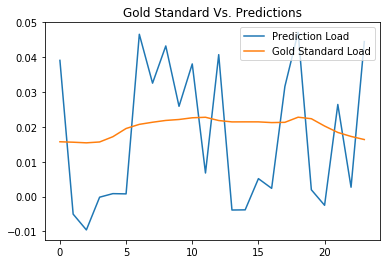

In [76]:
plotPredVsTrue(val_target, val_predictions, 0, 100)

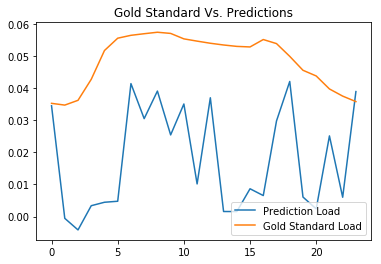

In [77]:
plotPredVsTrue(val_target, val_predictions, 0, 1)

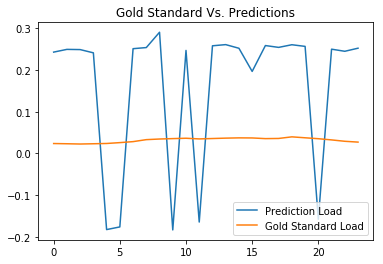

In [37]:
plotPredVsTrue(val_target, val_predictions, 10, 8)